# Simple DQN on Keras
On this example we will do a DQN (Without screen states) on the CartPole problem.
![alt text](imgs/dqn_algo.png "Algorithm")

### References
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time
* https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
* https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f

In [1]:
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

## Plot function
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_durations(durations_t):
    plt.figure(2)
    plt.clf()    
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.plot(durations_t)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:        
        plt.plot(moving_average(durations_t,20))

### Define Hyperparameters

In [2]:
train_episodes = 600              # max number of episodes to learn from
max_steps = 200                   # max steps in an episode
gamma = 0.99                      # future reward discount

# Exploration parameters
explore_start = 1.0               # exploration probability at start (Pure exploratory)
explore_stop = 0.01               # minimum exploration probability
decay_rate = 0.0001               # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16                  # number of units in each Q-network hidden layer
learning_rate = 0.001             # Q-network learning rate

# Memory parameters
memory_size = 10000               # memory capacity
batch_size = 32                   # experience mini-batch size
pretrain_length = batch_size*10   # number experiences to pretrain the memory

consecutive_win_threshold = 6     # Number of Consecutive wins before stop training

### Define Q-Network

In [3]:
class QNetwork:
    def __init__(self, env, learning_rate=0.01, state_size=4,
                 hidden_size=10):
        action_size = env.action_space.n
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',
                             input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)#, decay=1e-6)
        self.model.compile(loss='mse', optimizer=self.optimizer)
    
    def __call__(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)[0]
        # Act greedly
        action = np.argmax(Q_values)
        return action
    
    def q_values(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)
        return Q_values


# Initialize DQN Network
mainQN = QNetwork(env, hidden_size=hidden_size, learning_rate=learning_rate)



### Memory Buffer

In [4]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

memory = Memory(max_size=memory_size)

### Populate Replay Memory

In [5]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)    

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))

        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

### Training

In [6]:
# Initialize the simulation
env.reset()
rewards_per_episode = []

step = 0
num_consecutive_win = 0

# For each episodes
for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    # For each iteration per episode.
    while t < max_steps:
        step += 1
     
        # Epsilon Greedy Decay
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
        
        # Epsilon Greedy
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            action = mainQN(state)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)        
        total_reward += reward

        # Episode finish
        if done:
            # the episode ends so no next state
            next_state = np.zeros(state.shape)
            t = max_steps

            print('DONE! Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_p))
            
            rewards_per_episode.append(total_reward)
            
            # Early Stop
            if total_reward >= 199:
                num_consecutive_win += 1
                print('Win...')
            else:
                num_consecutive_win = 0                
            
            if num_consecutive_win > consecutive_win_threshold:                
                break

            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            env.reset()            
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1

        # Replay
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))

        # Sample experience from Replay Memory
        minibatch = memory.sample(batch_size)
        
        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
            inputs[i:i+1] = state_b
            target = reward_b
            # Check if all elements from next next_state_b are different than zero
            if not (next_state_b == np.zeros(state_b.shape)).all(axis=0):
                target_Q = mainQN.q_values(next_state_b)[0]
                target = reward_b + gamma * np.amax(mainQN.q_values(next_state_b)[0])
            targets[i] = mainQN.q_values(state_b)
            targets[i][action_b] = target
        
        # Update the model (In each episode end)
        mainQN.model.fit(inputs, targets, epochs=1, verbose=0)
    
    # Stop Earlier ...
    if num_consecutive_win > consecutive_win_threshold:
        print('Number of consecutive wins high, stop earlier...')
        break

DONE! Episode: 1 Total reward: 13.0 Explore P: 0.9987
DONE! Episode: 2 Total reward: 20.0 Explore P: 0.9967
DONE! Episode: 3 Total reward: 44.0 Explore P: 0.9924
DONE! Episode: 4 Total reward: 17.0 Explore P: 0.9907
DONE! Episode: 5 Total reward: 31.0 Explore P: 0.9877
DONE! Episode: 6 Total reward: 32.0 Explore P: 0.9846
DONE! Episode: 7 Total reward: 13.0 Explore P: 0.9833
DONE! Episode: 8 Total reward: 33.0 Explore P: 0.9801
DONE! Episode: 9 Total reward: 19.0 Explore P: 0.9783
DONE! Episode: 10 Total reward: 27.0 Explore P: 0.9757
DONE! Episode: 11 Total reward: 25.0 Explore P: 0.9732
DONE! Episode: 12 Total reward: 11.0 Explore P: 0.9722
DONE! Episode: 13 Total reward: 32.0 Explore P: 0.9691
DONE! Episode: 14 Total reward: 30.0 Explore P: 0.9662
DONE! Episode: 15 Total reward: 12.0 Explore P: 0.9651
DONE! Episode: 16 Total reward: 16.0 Explore P: 0.9636
DONE! Episode: 17 Total reward: 23.0 Explore P: 0.9614
DONE! Episode: 18 Total reward: 9.0 Explore P: 0.9605
DONE! Episode: 19 To

DONE! Episode: 150 Total reward: 28.0 Explore P: 0.7363
DONE! Episode: 151 Total reward: 33.0 Explore P: 0.7339
DONE! Episode: 152 Total reward: 18.0 Explore P: 0.7326
DONE! Episode: 153 Total reward: 13.0 Explore P: 0.7316
DONE! Episode: 154 Total reward: 45.0 Explore P: 0.7284
DONE! Episode: 155 Total reward: 18.0 Explore P: 0.7271
DONE! Episode: 156 Total reward: 36.0 Explore P: 0.7245
DONE! Episode: 157 Total reward: 54.0 Explore P: 0.7207
DONE! Episode: 158 Total reward: 22.0 Explore P: 0.7191
DONE! Episode: 159 Total reward: 15.0 Explore P: 0.7180
DONE! Episode: 160 Total reward: 19.0 Explore P: 0.7167
DONE! Episode: 161 Total reward: 13.0 Explore P: 0.7158
DONE! Episode: 162 Total reward: 15.0 Explore P: 0.7147
DONE! Episode: 163 Total reward: 15.0 Explore P: 0.7137
DONE! Episode: 164 Total reward: 21.0 Explore P: 0.7122
DONE! Episode: 165 Total reward: 18.0 Explore P: 0.7109
DONE! Episode: 166 Total reward: 14.0 Explore P: 0.7099
DONE! Episode: 167 Total reward: 30.0 Explore P:

DONE! Episode: 297 Total reward: 32.0 Explore P: 0.4416
DONE! Episode: 298 Total reward: 44.0 Explore P: 0.4398
DONE! Episode: 299 Total reward: 80.0 Explore P: 0.4363
DONE! Episode: 300 Total reward: 73.0 Explore P: 0.4332
DONE! Episode: 301 Total reward: 90.0 Explore P: 0.4294
DONE! Episode: 302 Total reward: 49.0 Explore P: 0.4274
DONE! Episode: 303 Total reward: 34.0 Explore P: 0.4260
DONE! Episode: 304 Total reward: 85.0 Explore P: 0.4224
DONE! Episode: 305 Total reward: 80.0 Explore P: 0.4192
DONE! Episode: 306 Total reward: 56.0 Explore P: 0.4169
DONE! Episode: 307 Total reward: 56.0 Explore P: 0.4146
DONE! Episode: 308 Total reward: 48.0 Explore P: 0.4127
DONE! Episode: 309 Total reward: 72.0 Explore P: 0.4098
DONE! Episode: 310 Total reward: 77.0 Explore P: 0.4067
DONE! Episode: 311 Total reward: 90.0 Explore P: 0.4032
DONE! Episode: 312 Total reward: 57.0 Explore P: 0.4009
DONE! Episode: 313 Total reward: 108.0 Explore P: 0.3967
DONE! Episode: 314 Total reward: 64.0 Explore P

### Plot Total Rewards per Episode

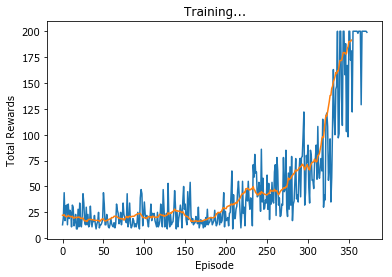

In [7]:
plot_durations(rewards_per_episode)

### Test trained Agent

In [8]:
# Reset environment
state = env.reset()

while True:    
    # Act greedly
    action = mainQN(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break